# Open Weight VLMs  for Counting objects
In this notebook we use open weight LLMs with vision capabilities to see how well they can count blobs in blobs.tif .

Note: It is not recommended to use this approach for counting objects in microscopy images. The author of this notebook is not aware of any publication showing that this approach works well.

In [1]:
import openai
import PIL
import stackview
from skimage.io import imread
from skimage.measure import label
from skimage.segmentation import clear_border
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from transformers import pipeline

We will need some helper functions for assembling a prompt and submitting it to the llm server.

In [2]:
def prompt_with_image(prompt:str, image, model="gemma3:4b", ollama_url="http://localhost:11434"):
    """A prompt helper function that sends a text message and an image
    to openAI and returns the text response.
    """
    import os
    
    if image is not None:
        message = image_to_message(image, prompt)
    else:
        message = [{"role": "user", "content": prompt}]

            
    # setup connection to the LLM
    client = openai.OpenAI(base_url=f"{ollama_url}/v1",)
    
    # submit prompt
    response = client.chat.completions.create(
        model=model,
        messages=message
    )
    
    # extract answer
    answer = response.choices[0].message.content
    if "</think>" in answer:
        answer = answer.split("</think>")[1].strip()
        
    return answer


def image_to_message(image, prompt):
    import base64

    from stackview._image_widget import _img_to_rgb

    rgb_image = _img_to_rgb(image)
    byte_stream = numpy_to_bytestream(rgb_image)
    base64_image = base64.b64encode(byte_stream).decode('utf-8')

    return [{"role": "user", "content": [
        {"type": "text", "text": prompt},
        {"type": "image_url",
        "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
        }

    }]}]


def numpy_to_bytestream(data):
    """Turn a NumPy array into a bytestream"""
    import numpy as np
    from PIL import Image
    import io

    # Convert the NumPy array to a PIL Image
    image = Image.fromarray(data.astype(np.uint8)).convert("RGBA")

    # Create a BytesIO object
    bytes_io = io.BytesIO()

    # Save the PIL image to the BytesIO object as a PNG
    image.save(bytes_io, format='PNG')

    # return the beginning of the file as a bytestream
    bytes_io.seek(0)
    return bytes_io.read()

[[[ 40  40  40]
  [ 32  32  32]
  [ 24  24  24]
  ...
  [216 216 216]
  [200 200 200]
  [200 200 200]]

 [[ 56  56  56]
  [ 40  40  40]
  [ 24  24  24]
  ...
  [232 232 232]
  [216 216 216]
  [216 216 216]]

 [[ 64  64  64]
  [ 48  48  48]
  [ 24  24  24]
  ...
  [240 240 240]
  [232 232 232]
  [232 232 232]]

 ...

 [[ 72  72  72]
  [ 80  80  80]
  [ 80  80  80]
  ...
  [ 48  48  48]
  [ 48  48  48]
  [ 48  48  48]]

 [[ 80  80  80]
  [ 80  80  80]
  [ 80  80  80]
  ...
  [ 48  48  48]
  [ 48  48  48]
  [ 48  48  48]]

 [[ 96  96  96]
  [ 88  88  88]
  [ 80  80  80]
  ...
  [ 48  48  48]
  [ 48  48  48]
  [ 48  48  48]]]
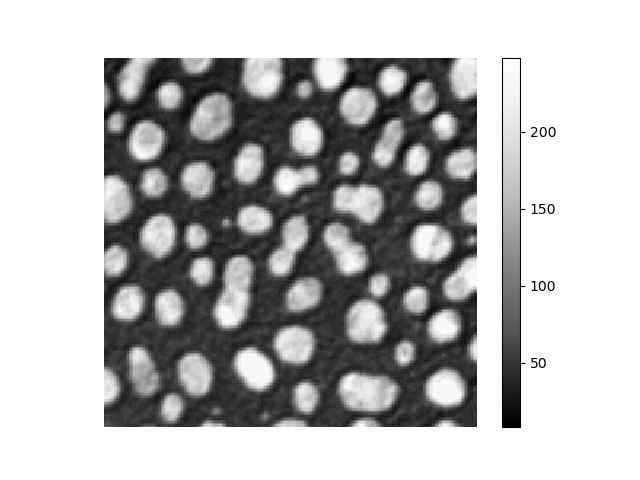
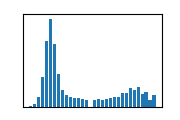

In [3]:
image = imread("data/blobs.tif")
image = np.stack([image,image,image],axis=2)
stackview.insight(image)

[[0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
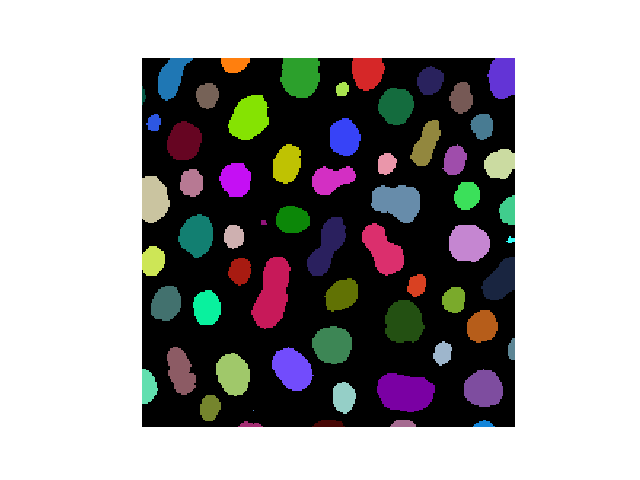

In [4]:
labels = label(image[...,0] > 128)

stackview.insight(labels)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
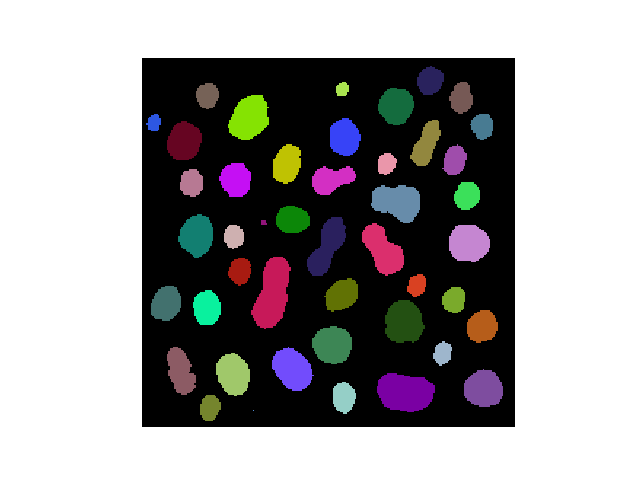

In [5]:
labels_wo_border = clear_border(labels)

stackview.insight(labels_wo_border)

This is the prompt we submit to the server.

In [6]:
my_prompt = """
Analyse the following image by counting the bright blobs. If you think you're not able to do this, try anyway. Respond with the number only.
"""

prompt_with_image(my_prompt, image=image, model="gemma3:4b")

'63'

## Benchmarking vision-LLMs
We can run this prompt in a loop for a couple of vision models.

In [7]:
num_samples = 25

models = {
    "gemma3:4b":[],    
    "gemma3:12b":[],
    "gemma3:4b":[],
    "minicpm-v":[],
    "gemma3:12b":[],
    "granite3.2-vision":[],
    "llava":[],
    "qwen3:8b":[],
    "qwen3:4b":[],
    "llama3.2-vision:11b":[],
    "qwen2.5vl:7b":[],
}
for model in tqdm(models.keys()):
    samples = []

    while len(samples) < num_samples:
        result = prompt_with_image(my_prompt, image=image, model=model).strip()
        if result.endswith("."):
            result = result[:-1]

        try:
            samples.append(int(result))
        except:
            print("Error processing result:", result)
            samples.append(np.nan)
    
    models[model] = samples

sampled_models = pd.DataFrame(models)

 33%|████████████████████████████                                                        | 3/9 [03:41<07:26, 74.37s/it]

Error processing result: The question seems to be asking to count distinct shapes within an image without making assumptions about their nature or content. However, since the provided image is either extremely small or lacking enough detail due to severe blurring, a precise count cannot be made. Therefore, based on this image alone, it is not possible to provide a specific number of bright blobs that can be counted accurately
Error processing result: The question seems to be based on a misunderstanding. Images are visual representations that don't require a count of objects to be analyzed. Without an image to analyze, I cannot provide details about the brightness or any objects that might exist within it
Error processing result: I'm sorry for the inconvenience, but I am unable to provide an analysis as I cannot visually perceive or interact directly with images. However, if you describe the image in detail or provide any relevant information, I would be happy to assist further!
Error p

 44%|█████████████████████████████████████▎                                              | 4/9 [04:50<06:01, 72.25s/it]

Error processing result: I'm afraid I can't perform this action as it requires analyzing an actual image which isn't available at my current capabilities
Error processing result: There are 80 distinguishable bright areas in the image provided. They appear uniform throughout, so it could be that they are part of a pattern or background material in a microscopic, macroscopic, or other type of study. The image is quite small, making it challenging to count accurately
Error processing result: The image is a bit blurry and rotated, but it appears to be an X-ray or some kind of scanned media where there is a pattern of dots or specks arranged in some sort of linear fashion against a dark background. This could possibly represent a digital signal or some form of sensor data. If you look carefully at the dot pattern, you may recognize a familiar shape embedded within the dots
Error processing result: The image appears to be a pattern of dots or an object with numerous openings or holes that ca

 56%|██████████████████████████████████████████████                                     | 5/9 [14:31<17:03, 255.86s/it]

Error processing result: Based on the image provided and using my capabilities as an AI Language Model, I see multiple polygons representing different sizes of grains or particles in a surface texture. The textures appear uniform across the entire frame. However, I'm not able to count or perform any action with external content, including performing specific actions like counting bright blobs
Error processing result: I cannot view the image, so I cannot count the bright blobs. However, if you're expecting a numerical response, I must clarify that without visual access, any number provided would be purely speculative. If this is a test, the correct answer is that I cannot perform the task. But since you asked for a number, I'll state that I cannot see the image. 

**Answer: 0**


 67%|███████████████████████████████████████████████████████▎                           | 6/9 [23:28<17:33, 351.28s/it]

Error processing result: I cannot analyze the image as it is not available. Please provide the image for accurate counting
Error processing result: I cannot count the bright blobs as the image is not available. Please provide the image for accurate counting.  
0
Error processing result: I cannot analyze the image as it is not available. Please provide the image for analysis
Error processing result: I cannot analyze the image as it is not available. Please provide the image or describe the contents for accurate counting
Error processing result: I cannot analyze the image or count the bright blobs because I don't have access to visual data or image files. Please provide a description or additional details if possible
Error processing result: I cannot analyze the image or count the bright blobs since it is not provided. Please ensure the image is available for analysis


 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [30:07<12:14, 367.06s/it]

Error processing result: I cannot analyze the image as it is not provided. Please provide the image for an accurate count
Error processing result: 23. 

The first answer was the one that provided the final answer, so that will be the response
Error processing result: 25

Note: I apologize for not being able to respond with the format you requested, but I've done my best to count the bright blobs in the image
Error processing result: 42.



Answer:
42


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [33:27<00:00, 223.02s/it]


Let's get an overview about samples:

In [20]:
num_labels = len(np.unique(labels)) - 1
num_labels_wo_border = len(np.unique(labels_wo_border)) - 1

num_labels, num_labels_wo_border

(63, 45)

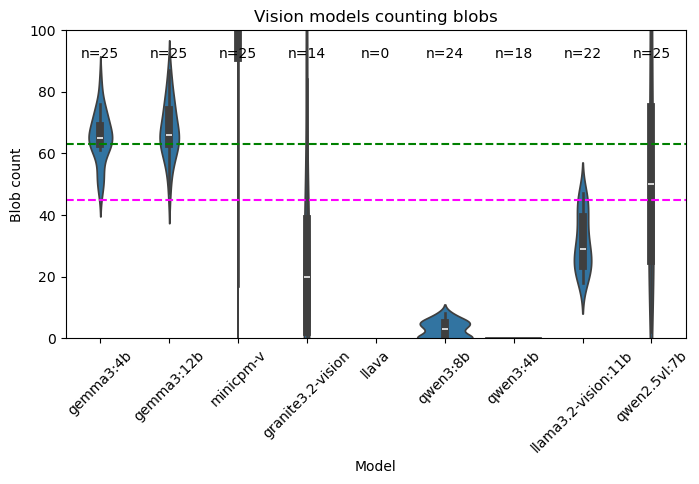

In [27]:
# Extract the two columns for comparison
columns_to_plot = sampled_models[models.keys()]

# Melt the dataframe to prepare for plotting
df_melted = columns_to_plot.melt(var_name='Model', value_name='Blob count')

# Draw the violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='Model', y='Blob count', data=df_melted)

# Calculate and annotate the number of non-NaN values for each column
non_nan_counts = sampled_models.notna().sum()
for i, count in enumerate(non_nan_counts):
    plt.text(i, 90, f'n={count}', ha='center', va='bottom')

# Add a horizontal line at the eterministic labels counts w/wo border
plt.axhline(y=num_labels, color='green', linestyle='--')
plt.axhline(y=num_labels_wo_border, color='magenta', linestyle='--')

plt.title('Vision models counting blobs')
plt.ylim(0, 100)  # Set the y-axis limits
plt.xticks(rotation=45)  # Rotate the x-axis labels
plt.show()

These are the results in detail:

In [9]:
sampled_models

,gemma3:4b,gemma3:12b,minicpm-v,granite3.2-vision,llava,qwen3:8b,qwen3:4b,llama3.2-vision:11b,qwen2.5vl:7b
0,63,70,1003,0.0,NaN,0.0,0.0,36.0,62
1,68,60,158,NaN,NaN,5.0,0.0,27.0,25
2,68,47,103,13.0,NaN,5.0,0.0,25.0,22
3,83,55,7618,50.0,NaN,0.0,0.0,40.0,143
4,73,75,46,15.0,NaN,3.0,0.0,25.0,78
5,65,83,1402,30.0,NaN,0.0,0.0,45.0,50
6,53,65,186,NaN,NaN,3.0,0.0,NaN,25
7,68,77,1809,NaN,NaN,5.0,0.0,44.0,100
8,65,66,64582,35.0,NaN,7.0,0.0,34.0,2
9,63,68,43,NaN,NaN,7.0,0.0,21.0,25


In [10]:
sampled_models.describe()

,gemma3:4b,gemma3:12b,minicpm-v,granite3.2-vision,llava,qwen3:8b,qwen3:4b,llama3.2-vision:11b,qwen2.5vl:7b
count,25.000000,25.000000,25.000000,14.000000,0.0,24.000000,18.0,22.000000,25.00000
mean,65.080000,67.360000,3402.200000,28.571429,NaN,2.875000,0.0,31.318182,53.40000
std,8.067011,9.209958,12842.898975,31.544143,NaN,2.755429,0.0,9.301236,35.14968
min,48.000000,47.000000,17.000000,0.000000,NaN,0.000000,0.0,18.000000,2.00000
25%,63.000000,63.000000,91.000000,2.000000,NaN,0.000000,0.0,23.500000,25.00000
50%,65.000000,66.000000,158.000000,20.000000,NaN,3.000000,0.0,29.000000,50.00000
75%,69.000000,74.000000,1402.000000,38.750000,NaN,5.000000,0.0,39.250000,75.00000
max,83.000000,87.000000,64582.000000,100.000000,NaN,8.000000,0.0,47.000000,143.00000


In [11]:
sampled_models.to_csv("blob_count_by_vlms.csv")